In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [ ]:
# Set up environment variables
project_id = 'helpful-kingdom-430601-s1'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'


In [ ]:
auth.authenticate_user()

#SQL CODE SECTION (This section is the preprocessing of the initial admission records, and measurements of Hear rate, mean arterial pressure, respiratory rate, temperature, serum glucose levels, O2 pulse oximetry that are merged on dataset_measurements.csv)

# INITIAL ADMISSION

In [ ]:
#Checking lactate codes
df_patients = f"""
    SELECT *
    FROM physionet-data.mimiciv_icu.icustays AS icustay
    INNER JOIN physionet-data.mimiciv_hosp.admissions AS admi
    ON icustay.hadm_id = admi.hadm_id
    WHERE (icustay.los >= 1 AND admi.deathtime IS NULL AND icustay.los <= 10)
       OR (admi.deathtime <= icustay.outtime AND icustay.los >= 1 AND icustay.los <= 10)
       OR (icustay.los >= 1 AND icustay.los <= 10 AND admi.deathtime > icustay.outtime)
"""
df_patient_frame = run_query(df_patients)
df_patient_frame.head(10)

# Respiratory rate

In [ ]:
df_rr_vitals = f"""
SELECT ce.subject_id,
       ce.hadm_id,
       ce.valueuom,
       ce.stay_id,
       ce.valuenum,
       ce.value,
       ce.itemid,
       ce.charttime,
       ce.storetime,
       items.label
FROM physionet-data.mimiciv_icu.chartevents AS ce
INNER JOIN physionet-data.mimiciv_icu.d_items AS items
ON ce.itemid = items.itemid
WHERE ce.itemid IN (220210)
  AND ce.valuenum IS NOT NULL;
    """
df_rr = run_query(df_rr_vitals)
df_rr.head(10)

# NON-INVASIVE MEAN ARTERIAL PRESSURE

In [ ]:
df_map_vitals = f"""
SELECT ce.subject_id,
       ce.hadm_id,
       ce.valueuom,
       ce.stay_id,
       ce.valuenum,
       ce.value,
       ce.itemid,
       ce.charttime,
       ce.storetime,
       items.label
FROM physionet-data.mimiciv_icu.chartevents AS ce
INNER JOIN physionet-data.mimiciv_icu.d_items AS items
ON ce.itemid = items.itemid
WHERE ce.itemid IN (220181)
  AND ce.valuenum IS NOT NULL;
    """
df_map = run_query(df_map_vitals)
df_map.head(10)

# HEART RATE

In [ ]:
df_HR_vitals = f"""
SELECT *
FROM
   physionet-data.mimic_icu.chartevents
WHERE itemid in (220045)
ORDER BY subject_id, charttime
"""
df_HR = run_query(df_HR_vitals)
df_HR.head(10)

# SERUM GLUCOSE

In [ ]:
df_SG_vitals = f"""
SELECT *
FROM
   physionet-data.mimic_icu.chartevents
WHERE itemid in (220621)
ORDER BY subject_id, charttime
"""
df_SG = run_query(df_SG_vitals)
df_SG.head(10)

# O2 Pulse Oximetry

In [ ]:
df_O2_vitals = f"""
SELECT *
FROM
   physionet-data.mimic_icu.chartevents
WHERE itemid in (220277)
ORDER BY subject_id, charttime
"""
df_O2 = run_query(df_O2_vitals)
df_O2.head(10)

# BODY TEMPERATURE

In [ ]:
df_T_vitals = f"""
SELECT *
FROM
   physionet-data.mimic_icu.chartevents
WHERE itemid in (223761)
ORDER BY subject_id, charttime
"""
df_T = run_query(df_T_vitals)
df_T.head(10)

In [ ]:
from datetime import timedelta
import pandas as pd

def dayData(patients, measurements, timelabel, label1, label2):
    data_ranges = []

    # Convert 'intime' to datetime if not already
    patients['intime'] = pd.to_datetime(patients['intime'])
    patients = patients.sort_values(by="intime")

    # Group by hadm_id and stay_id
    for (hadmi_id, stay_id), data in patients.groupby([label1, label2]):

        # Iterate through each patient row
        for index, row in data.iterrows():
            intime = row['intime']

            # Filter measurements for the current hadm_id and stay_id
            data_collect = measurements[(measurements[label1] == hadmi_id) & (measurements[label2] == stay_id)]

            # Ensure there are valid rows in data_collect
            if not data_collect.empty:

                # Convert 'charttime' to datetime format
                data_collect[timelabel] = pd.to_datetime(data_collect[timelabel])

                # Find records where charttime is within 24 hours of intime
                valid_ranges = data_collect[
                    (data_collect[timelabel] - intime).abs() <= timedelta(hours=24)
                ]

                # Append valid ranges if not empty
                if not valid_ranges.empty:
                    data_ranges.append(valid_ranges)

    # Concatenate all valid ranges and return
    return pd.concat(data_ranges, ignore_index=True) if data_ranges else pd.DataFrame()

In [ ]:
earliest_rows = df_patient_frame.sort_values(by='intime').drop_duplicates(subset=['subject_id', 'hadm_id'], keep='first')
# Reset index if needed
earliest_rows = earliest_rows.reset_index(drop=True)
print(len(earliest_rows))

In [ ]:
valid_vitals_HR_data = df_HR[df_HR["label"] == "Heart Rate"]
valid_vitals_data_HR = dayData(earliest_rows, valid_vitals_HR_data , 'charttime', "hadm_id", "stay_id")
print(len(valid_vitals_data_HR))
valid_noninvasive = dayData(earliest_rows, df_map, 'charttime', "hadm_id", "stay_id")
print(len(valid_noninvasive))
valid_glucose = dayData(earliest_rows, df_SG, 'charttime', "hadm_id", "stay_id")
print(len(valid_glucose))
valid_O2SaturationPulseoximetry_frame = dayData(earliest_rows, df_O2, 'charttime', "hadm_id", "stay_id")
print(len(valid_O2SaturationPulseoximetry_frame))
valid_temperature_frame = dayData(earliest_rows, df_T, 'charttime', "hadm_id", "stay_id")
print(len(valid_temperature_frame))
valid_respiratoryrate_frame = dayData(earliest_rows, df_rr, 'charttime', "hadm_id", "stay_id")
print(len(valid_respiratoryrate_frame))

In [ ]:

#valid_vitals_HR_data = valid_vitals_data[valid_vitals_data["label"] == "Heart Rate"]
valid_vitals_HR_data_grouped = valid_vitals_data_HR.groupby(['subject_id', 'hadm_id', "stay_id"], as_index=False).agg(
    hr_min=('valuenum', 'min'),
    hr_max=('valuenum', 'max')
)
print(len(valid_vitals_HR_data))

valid_noninvasive_grouped = valid_noninvasive.groupby(['subject_id', 'hadm_id', "stay_id"], as_index=False).agg(
    NIMAP_min=('valuenum', 'min'),
    NIMAP_max=('valuenum', 'max')
)
print(len(valid_noninvasive_grouped))

valid_glucose_grouped = valid_glucose.groupby(['subject_id', 'hadm_id', "stay_id"], as_index=False).agg(
    mean_glucose=('valuenum', 'mean'),
    max_glucose=('valuenum', 'max'),
    min_glucose=('valuenum', 'min'),
)
print(len(valid_glucose_grouped))

valid_temperature_frame_grouped = valid_temperature_frame.groupby(['subject_id', 'hadm_id', "stay_id"], as_index=False).agg(
    mean_temperature=('valuenum', 'mean'),
    max_temperature=('valuenum', 'max'),
    min_temperature=('valuenum', 'min'),
)
print(len(valid_temperature_frame_grouped))

valid_respiratoryrate_frame_grouped = valid_respiratoryrate_frame.groupby(['subject_id', 'hadm_id', "stay_id"], as_index=False).agg(
    mean_RR=('valuenum', 'mean'),
    max_RR=('valuenum', 'max'),
    min_RR=('valuenum', 'min'),
)
print(len(valid_respiratoryrate_frame_grouped))

In [ ]:
hr_columns = valid_vitals_HR_data_grouped[['hadm_id', 'stay_id', 'hr_min', 'hr_max']]
patients_map_hr = pd.merge(earliest_rows, hr_columns, on=['hadm_id', 'stay_id'], how="left")
print(len(patients_map_hr[['hadm_id', 'stay_id']]))
NIMAP_columns = valid_noninvasive_grouped[['hadm_id', 'stay_id', 'NIMAP_min', 'NIMAP_max']]
patients_map_hr_NIMAP = pd.merge(patients_map_hr , NIMAP_columns,on=['hadm_id', 'stay_id'], how="left")
print(len(patients_map_hr_NIMAP[['hadm_id', 'stay_id']]))
glucose_columns = valid_glucose_grouped[['hadm_id', 'stay_id', 'mean_glucose', 'max_glucose', 'min_glucose']]
patients_map_hr_NIMAP_glucose = pd.merge(patients_map_hr_NIMAP, glucose_columns,on=['hadm_id', 'stay_id'], how="left")
print(len(patients_map_hr_NIMAP_glucose[['hadm_id', 'stay_id']]))

earliest_rows_O2 = valid_O2SaturationPulseoximetry_frame.sort_values(by='charttime').drop_duplicates(subset=['subject_id', 'hadm_id'], keep='first')
earliest_rows_O2  = earliest_rows_O2 .reset_index(drop=True)
print(len(earliest_rows_O2))

O2SaturationPulseoximetry_columns = earliest_rows_O2[['hadm_id', 'stay_id', 'valuenum']]
patients_map_hr_NIMAP_glucose_O2 = pd.merge(patients_map_hr_NIMAP_glucose, O2SaturationPulseoximetry_columns,on=['hadm_id', 'stay_id'], how="left")
print(len(patients_map_hr_NIMAP_glucose_O2[['hadm_id', 'stay_id']]))

temperature_columns = valid_temperature_frame_grouped[['hadm_id', 'stay_id',"mean_temperature", "min_temperature", "max_temperature"]]
patients_map_hr_NIMAP_glucose_O2_temp = pd.merge(patients_map_hr_NIMAP_glucose_O2, temperature_columns,on=['hadm_id', 'stay_id'], how="left")
print(len(patients_map_hr_NIMAP_glucose_O2_temp[['hadm_id', 'stay_id']]))

RR_columns = valid_respiratoryrate_frame_grouped[['hadm_id', 'stay_id',"mean_RR", "min_RR", "max_RR"]]
patients_map_hr_NIMAP_glucose_O2_temp_rr = pd.merge(patients_map_hr_NIMAP_glucose_O2_temp, RR_columns,on=['hadm_id', 'stay_id'], how="left")
print(len(patients_map_hr_NIMAP_glucose_O2_temp_rr[['hadm_id', 'stay_id']]))

In [ ]:
subset_data = patients_map_hr_NIMAP_glucose_O2_temp_rr
final_data = subset_data[["hadm_id", "stay_id", "intime", "outtime", "hr_min", "hr_max", "NIMAP_min", "NIMAP_max", "mean_glucose", 'max_glucose', 'min_glucose', "valuenum", "mean_temperature", "min_temperature", "max_temperature", "mean_RR", "min_RR", "max_RR"]]

In [ ]:
final_data.to_csv('dataset_measurements.csv', index=False)

#SECTION: READ THE REST OF THE FEATURES PROCESSED, AND MERGED AS A FINAL DATASET

In [ ]:
file_path = '/content/dataset_measurements.csv'
my_dataset = pd.read_csv(file_path)
print(len(my_dataset))

file_path = '/content/creatinine.csv'
df_creatinine_frame = pd.read_csv(file_path)
print(len(df_creatinine_frame))

file_path = '/content/potassium.csv'
df_potassium_frame = pd.read_csv(file_path)
print(len(df_potassium_frame))


file_path = '/content/gender_and_age.csv'
df_gender_and_age_frame = pd.read_csv(file_path)
print(len(df_gender_and_age_frame))


file_path = '/content/ph.csv'
df_ph_frame = pd.read_csv(file_path)
print(len(df_ph_frame))

file_path = '/content/sodium.csv'
df_sodium_frame = pd.read_csv(file_path)
print(len(df_sodium_frame))

file_path = '/content/label.csv'
labels = pd.read_csv(file_path)
print(len(labels))

In [ ]:
#patients_ids = earliest_rows[['hadm_id', 'stay_id']]
df1 = pd.merge(my_dataset, df_creatinine_frame, on=['hadm_id', 'stay_id'], how="left")
df2 = pd.merge(df1, df_potassium_frame, on=['hadm_id', "stay_id"], how="left")
df3 = pd.merge(df2, df_ph_frame, on=['hadm_id', "stay_id"], how="left")
df4 = pd.merge(df3, df_sodium_frame, on=['hadm_id', 'stay_id'], how="left")
df5 = pd.merge(df4, df_gender_and_age_frame, on=['hadm_id'], how="left")
df6 = pd.merge(df5, labels, on=['hadm_id'], how="left")

In [ ]:
df6.describe()

,hadm_id,stay_id,hr_min,hr_max,NIMAP_min,NIMAP_max,mean_glucose,max_glucose,min_glucose,valuenum,...,max_potassium,avg_potassium,min_ph,max_ph,avg_ph,min_sodium,max_sodium,avg_sodium,subject_id,anchor_age
count,4.927400e+04,4.927400e+04,49233.000000,4.923300e+04,44639.000000,4.463900e+04,48431.000000,48431.000000,48431.000000,49225.000000,...,48626.000000,48626.000000,33638.000000,33638.000000,33638.000000,48663.000000,48663.000000,48663.000000,4.927400e+04,49274.000000
mean,2.498240e+07,3.498612e+07,70.887915,3.055507e+02,60.887426,1.435730e+02,288.821567,630.818050,141.856332,97.181940,...,107.258854,38.466053,96.016995,572.066743,195.959013,137.239928,221.597908,165.737299,1.500125e+07,63.731907
std,2.884455e+06,2.889334e+06,15.149289,4.506793e+04,108.868492,5.975545e+03,7939.785848,21784.062585,4543.637296,6.287725,...,10139.826127,3504.411824,9443.418411,23759.752340,10768.434749,5.079450,9064.758681,3160.046662,2.890392e+06,16.584934
min,2.000015e+07,3.000015e+07,0.000000,3.100000e+01,-22767.000000,0.000000e+00,32.000000,32.000000,0.000000,0.000000,...,2.100000,2.100000,0.000000,5.000000,3.720000,0.000000,107.000000,73.300000,1.000122e+07,18.000000
25%,2.249090e+07,3.248755e+07,60.000000,8.800000e+01,53.000000,8.500000e+01,104.666667,109.000000,96.000000,96.000000,...,4.000000,3.800000,6.500000,7.350000,7.015000,135.000000,137.000000,136.000000,1.249840e+07,54.000000
50%,2.495833e+07,3.497467e+07,70.000000,1.000000e+02,61.000000,9.800000e+01,124.000000,133.000000,113.000000,98.000000,...,4.300000,4.100000,7.290000,7.410000,7.342857,138.000000,139.000000,138.500000,1.499370e+07,65.000000
75%,2.747500e+07,3.747762e+07,80.000000,1.140000e+02,69.000000,1.110000e+02,153.500000,172.000000,136.000000,100.000000,...,4.700000,4.500000,7.360000,7.450000,7.397500,140.000000,142.000000,141.000000,1.752377e+07,76.000000
max,2.999983e+07,3.999981e+07,163.000000,1.000000e+07,215.000000,1.234570e+06,999999.000000,999999.000000,999999.000000,963.000000,...,999999.000000,500001.600000,999999.000000,999999.000000,999999.000000,175.000000,999999.000000,500068.500000,1.999999e+07,91.000000


# PREPROCESSING AFTER MERGE ALL THE FEATURES

In [ ]:
df6['label'] = df6['deathtime'].apply(lambda x: 1 if pd.notna(x) and str(x).strip() else 0)

In [ ]:
label_counts = df6["label"].value_counts()
print("Unique label counts:\n", label_counts)

# Print the total number of unique labels
print("Total number of unique labels:", len(label_counts))

Unique label counts:
 label
0    44534
1     4740
Name: count, dtype: int64
Total number of unique labels: 2


In [ ]:
df6['gender_numeric'] = df6['gender'].apply(lambda x: 1 if x == 'M' else (0 if x == 'F' else np.nan))

In [ ]:
df6 = df6.drop(columns=['gender', 'deathtime'])

In [ ]:
numeric_df6 = df6.select_dtypes(include=[np.number])
#print(numeric_df6)
id_columns = ['hadm_id', 'stay_id']
numeric_columns = df6.select_dtypes(include=['number']).columns.difference(id_columns)
#print(numeric_columns)
filtered_df = df6[(df6[numeric_columns] < 10000) & (df6[numeric_columns] > -10000)]
print(filtered_df.describe())

       hadm_id  stay_id        hr_min        hr_max     NIMAP_min  \
count      0.0      0.0  49233.000000  49232.000000  44638.000000   
mean       NaN      NaN     70.887915    102.436937     61.398827   
std        NaN      NaN     15.149289     42.219429     13.337996   
min        NaN      NaN      0.000000     31.000000      0.000000   
25%        NaN      NaN     60.000000     88.000000     53.000000   
50%        NaN      NaN     70.000000    100.000000     61.000000   
75%        NaN      NaN     80.000000    114.000000     69.000000   
max        NaN      NaN    163.000000   6262.000000    215.000000   

          NIMAP_max  mean_glucose   max_glucose   min_glucose      valuenum  \
count  44632.000000  48408.000000  48408.000000  48430.000000  49225.000000   
mean     101.685450    137.379050    155.990167    121.210923     97.181940   
std      114.284035     53.347950     87.803682     41.884332      6.287725   
min        0.000000     32.000000     32.000000      0.000000 

In [ ]:
print(len(filtered_df))
df_filtered_last = filtered_df.drop(columns=["subject_id", "hadm_id", "stay_id", "label"])
df_filtered_last.describe()

49274


,hr_min,hr_max,NIMAP_min,NIMAP_max,mean_glucose,max_glucose,min_glucose,valuenum,mean_temperature,min_temperature,...,max_potassium,avg_potassium,min_ph,max_ph,avg_ph,min_sodium,max_sodium,avg_sodium,anchor_age,gender_numeric
count,49233.000000,49232.000000,44638.000000,44632.000000,48408.000000,48408.000000,48430.000000,49225.000000,45827.000000,45827.000000,...,48621.000000,48621.000000,33635.000000,33619.000000,33619.000000,48663.000000,48659.000000,48659.000000,49274.000000,49274.000000
mean,70.887915,102.436937,61.398827,101.685450,137.379050,155.990167,121.210923,97.181940,98.317431,97.250343,...,4.433764,4.191017,6.832843,7.234008,7.090457,137.239928,139.411476,138.342028,63.731907,0.561513
std,15.149289,42.219429,13.337996,114.284035,53.347950,87.803682,41.884332,6.287725,8.308099,4.388757,...,1.043074,0.592687,0.812491,0.560676,0.572059,5.079450,4.863206,4.717398,16.584934,0.496207
min,0.000000,31.000000,0.000000,0.000000,32.000000,32.000000,0.000000,0.000000,0.000000,0.000000,...,2.100000,2.100000,0.000000,5.000000,3.720000,0.000000,107.000000,73.300000,18.000000,0.000000
25%,60.000000,88.000000,53.000000,85.000000,104.666667,109.000000,96.000000,96.000000,97.900000,97.200000,...,4.000000,3.800000,6.500000,7.350000,7.015000,135.000000,137.000000,136.000000,54.000000,0.000000
50%,70.000000,100.000000,61.000000,98.000000,124.000000,133.000000,113.000000,98.000000,98.266667,97.600000,...,4.300000,4.100000,7.290000,7.410000,7.342500,138.000000,139.000000,138.500000,65.000000,1.000000
75%,80.000000,114.000000,69.000000,111.000000,153.500000,172.000000,136.000000,100.000000,98.714286,98.000000,...,4.700000,4.500000,7.360000,7.450000,7.397500,140.000000,142.000000,141.000000,76.000000,1.000000
max,163.000000,6262.000000,215.000000,9292.000000,1016.000000,2440.000000,1016.000000,963.000000,1720.933333,103.600000,...,165.000000,44.050000,9.000000,9.000000,9.000000,175.000000,214.000000,179.000000,91.000000,1.000000


In [ ]:
def replace_outliers_with_nan(df):
    # Calculate the IQR for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers and replace them with NaN
    df_out = df.mask((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
    return df_out

In [ ]:
dataset_replaced = replace_outliers_with_nan(df_filtered_last)

In [ ]:
print(dataset_replaced.describe())

             hr_min        hr_max     NIMAP_min     NIMAP_max  mean_glucose  \
count  48584.000000  48467.000000  43583.000000  43627.000000  45449.000000   
mean      70.609166    101.189001     61.258128     98.184267    127.552337   
std       14.085603     18.618702     11.958570     18.582072     33.480486   
min       30.000000     49.000000     29.000000     46.000000     32.000000   
25%       60.000000     88.000000     53.000000     85.000000    103.000000   
50%       70.000000     99.000000     61.000000     97.000000    122.000000   
75%       80.000000    113.000000     69.000000    110.000000    146.000000   
max      110.000000    153.000000     93.000000    150.000000    226.666667   

        max_glucose   min_glucose      valuenum  mean_temperature  \
count  44825.000000  45896.000000  47626.000000      42901.000000   
mean     137.858226    114.742527     97.598434         98.297999   
std       41.669045     28.296632      2.623524          0.620521   
min       32

In [ ]:
print(len(dataset_replaced))

49274


In [ ]:
dataset_replaced["label"] = filtered_df["label"]

In [ ]:
df_cleaned = dataset_replaced.dropna(thresh=len(dataset_replaced.columns) - 8)

In [ ]:
df_cleaned.describe()

,hr_min,hr_max,NIMAP_min,NIMAP_max,mean_glucose,max_glucose,min_glucose,valuenum,mean_temperature,min_temperature,...,avg_potassium,min_ph,max_ph,avg_ph,min_sodium,max_sodium,avg_sodium,anchor_age,gender_numeric,label
count,45582.000000,45438.000000,41062.000000,41106.000000,43737.000000,43182.000000,43960.000000,44736.000000,40756.000000,39994.000000,...,45411.000000,29651.000000,27809.000000,28491.000000,44506.000000,44583.000000,44817.000000,45768.000000,46099.000000,46099.000000
mean,70.550584,101.189121,61.394964,98.043862,127.427155,137.531772,114.896269,97.616685,98.303398,97.621356,...,4.142052,6.998373,7.413689,7.263598,137.673460,139.478590,138.564590,64.155676,0.559340,0.087681
std,14.038538,18.550686,11.862647,18.518513,33.141583,41.241838,28.034453,2.616986,0.618031,0.637137,...,0.488363,0.625720,0.064397,0.244407,3.697193,3.615539,3.574187,16.175071,0.496472,0.282833
min,30.000000,49.000000,29.000000,46.000000,34.000000,35.000000,36.000000,90.000000,96.680000,96.000000,...,2.750000,5.500000,7.200000,6.442000,128.000000,130.000000,128.500000,21.000000,0.000000,0.000000
25%,60.000000,88.000000,53.000000,85.000000,103.500000,108.000000,95.000000,96.000000,97.918182,97.300000,...,3.800000,7.000000,7.370000,7.250000,135.000000,137.000000,136.333333,54.000000,0.000000,0.000000
50%,70.000000,99.000000,61.000000,97.000000,122.000000,129.000000,112.000000,98.000000,98.266667,97.700000,...,4.100000,7.310000,7.420000,7.358182,138.000000,140.000000,138.666667,66.000000,1.000000,0.000000
75%,80.000000,113.000000,69.000000,110.000000,146.000000,159.000000,132.000000,100.000000,98.666667,98.000000,...,4.450000,7.370000,7.460000,7.402000,140.000000,142.000000,141.000000,76.000000,1.000000,0.000000
max,110.000000,153.000000,93.000000,150.000000,226.666667,266.000000,196.000000,100.000000,99.933333,99.100000,...,5.550000,8.500000,7.600000,7.960000,147.000000,149.000000,148.500000,91.000000,1.000000,1.000000


In [ ]:
print(len(df_cleaned))

46099


In [ ]:
df_cleaned_filled = df_cleaned.apply(lambda x: x.fillna(x.median()), axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-30-d652675fc771>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned_filled = df_cleaned.apply(lambda x: x.fillna(x.median()), axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
<ipython-input-30-d652675fc771>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', 

In [ ]:
df_cleaned_filled.describe()

,intime,outtime,hr_min,hr_max,NIMAP_min,NIMAP_max,mean_glucose,max_glucose,min_glucose,valuenum,...,avg_potassium,min_ph,max_ph,avg_ph,min_sodium,max_sodium,avg_sodium,anchor_age,gender_numeric,label
count,0.0,0.0,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,...,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000,46099.000000
mean,NaN,NaN,70.544409,101.157732,61.351808,97.930801,127.149081,136.991909,114.761882,97.628018,...,4.141424,7.109561,7.416193,7.299725,137.684744,139.495737,138.567429,64.168919,0.559340,0.087681
std,NaN,NaN,13.959713,18.419045,11.196483,17.489891,32.303524,39.969671,27.383090,2.578825,...,0.484732,0.523559,0.050111,0.197559,3.633239,3.556806,3.524177,16.117647,0.496472,0.282833
min,NaN,NaN,30.000000,49.000000,29.000000,46.000000,34.000000,35.000000,36.000000,90.000000,...,2.750000,5.500000,7.200000,6.442000,128.000000,130.000000,128.500000,21.000000,0.000000,0.000000
25%,NaN,NaN,60.000000,88.000000,54.000000,86.000000,104.500000,109.000000,96.000000,96.000000,...,3.800000,7.270000,7.400000,7.336667,135.000000,137.000000,136.500000,54.000000,0.000000,0.000000
50%,NaN,NaN,70.000000,99.000000,61.000000,97.000000,122.000000,129.000000,112.000000,98.000000,...,4.100000,7.310000,7.420000,7.358182,138.000000,140.000000,138.666667,66.000000,1.000000,0.000000
75%,NaN,NaN,80.000000,113.000000,68.000000,108.000000,144.000000,156.000000,130.000000,100.000000,...,4.450000,7.330000,7.430000,7.375000,140.000000,142.000000,141.000000,76.000000,1.000000,0.000000
max,NaN,NaN,110.000000,153.000000,93.000000,150.000000,226.666667,266.000000,196.000000,100.000000,...,5.550000,8.500000,7.600000,7.960000,147.000000,149.000000,148.500000,91.000000,1.000000,1.000000


In [ ]:
df_cleaned_filled2 = df_cleaned_filled.drop(columns=["intime", "outtime"])

In [ ]:
df_cleaned_filled2.to_csv("final_dataset_preprocessed_corrected.csv", index=False)

#TO REPLICATE MODELS RESULTS READ full_training.csv and full_testing.csv files

In [ ]:
file_path = '/content/full_training.csv'
full_training = pd.read_csv(file_path)
print(len(full_training))

file_path = '/content/full_testing.csv'
full_testing = pd.read_csv(file_path)
print(len(full_testing))

44099


# NORMAL AND ABNORMAL RANGES

In [49]:
# Define normal ranges for each variable
normal_ranges = {
    'hr_min': (60, 100), 'hr_max': (60, 100),
    'NIMAP_min': (80, 120), 'NIMAP_max': (80, 120),
    'mean_glucose': (72, 108), 'max_glucose': (72, 108), 'min_glucose': (72, 108),
    'mean_temperature': (97, 99), 'min_temperature': (97, 99), 'max_temperature': (97, 99),
    'mean_RR': (12, 20), 'min_RR': (12, 20), 'max_RR': (12, 20),
    'min_potassium': (3.5, 5.0), 'max_potassium': (3.5, 5.0), 'avg_potassium': (3.5, 5.0),
    'min_ph': (7.35, 7.45), 'max_ph': (7.35, 7.45), 'avg_ph': (7.35, 7.45),
    'min_sodium': (135, 145), 'max_sodium': (135, 145), 'avg_sodium': (135, 145),
    'anchor_age': (1, 100), 'valuenum': (95, 100)
}

# Create a DataFrame to store the counts
range_counts = pd.DataFrame(columns=['In Range', 'Out of Range'], index=normal_ranges.keys())

# Calculate the number of rows within and out of range for each feature
for feature, (lower, upper) in normal_ranges.items():
    in_range_count = df_cleaned_filled2[(df_cleaned_filled2[feature] >= lower) & (df_cleaned_filled2[feature] <= upper)].shape[0]
    out_range_count = df_cleaned_filled2.shape[0] - in_range_count
    range_counts.loc[feature] = [in_range_count, out_range_count]

# Handle creatinine levels based on gender
# Assuming 'gender_numeric' is 0 for female and 1 for male
male_in_range = df_cleaned_filled2[(df_cleaned_filled2['gender_numeric'] == 1) &
                                   (df_cleaned_filled2['min_creatinine'] >= 0.7) &
                                   (df_cleaned_filled2['max_creatinine'] <= 1.3)].shape[0]
female_in_range = df_cleaned_filled2[(df_cleaned_filled2['gender_numeric'] == 0) &
                                     (df_cleaned_filled2['min_creatinine'] >= 0.6) &
                                     (df_cleaned_filled2['max_creatinine'] <= 1.1)].shape[0]
in_range_creatinine = male_in_range + female_in_range
out_range_creatinine = df_cleaned_filled2.shape[0] - in_range_creatinine
range_counts.loc['creatinine'] = [in_range_creatinine, out_range_creatinine]

# Print the result
print(range_counts)
print(female_in_range)
print(male_in_range)

                 In Range Out of Range
hr_min              35135        10964
hr_max              24150        21949
NIMAP_min            3069        43030
NIMAP_max           34499        11600
mean_glucose        13272        32827
max_glucose         10884        35215
min_glucose         18264        27835
mean_temperature    39855         6244
min_temperature     40461         5638
max_temperature     29178        16921
mean_RR             30818        15281
min_RR              35327        10772
max_RR              17001        29098
min_potassium       37804         8295
max_potassium       40191         5908
avg_potassium       40425         5674
min_ph               8736        37363
max_ph              35043        11056
avg_ph              31003        15096
min_sodium          37055         9044
max_sodium          39912         6187
avg_sodium          38622         7477
anchor_age          46099            0
valuenum            39685         6414
creatinine          28633

In [48]:
# Define normal ranges for creatinine based on gender
creatinine_ranges = {
    'min_creatinine': {'male': (0.7, 1.3), 'female': (0.6, 1.1)},
    'max_creatinine': {'male': (0.7, 1.3), 'female': (0.6, 1.1)},
    'avg_creatinine': {'male': (0.7, 1.3), 'female': (0.6, 1.1)}
}

# Create a DataFrame to store the counts for each creatinine variable
creatinine_counts = pd.DataFrame(columns=['In Range', 'Out of Range'], index=creatinine_ranges.keys())

# Calculate the number of rows within and out of range for each creatinine variable
for feature in creatinine_ranges.keys():
    # Male in-range count
    male_in_range = df_cleaned_filled2[
        (df_cleaned_filled2['gender_numeric'] == 1) &
        (df_cleaned_filled2[feature] >= creatinine_ranges[feature]['male'][0]) &
        (df_cleaned_filled2[feature] <= creatinine_ranges[feature]['male'][1])
    ].shape[0]

    # Female in-range count
    female_in_range = df_cleaned_filled2[
        (df_cleaned_filled2['gender_numeric'] == 0) &
        (df_cleaned_filled2[feature] >= creatinine_ranges[feature]['female'][0]) &
        (df_cleaned_filled2[feature] <= creatinine_ranges[feature]['female'][1])
    ].shape[0]

    # Total in-range count for the current feature
    in_range_count = male_in_range + female_in_range

    # Out-of-range count for the current feature
    out_range_count = df_cleaned_filled2.shape[0] - in_range_count

    # Store the counts in the DataFrame
    creatinine_counts.loc[feature] = [in_range_count, out_range_count]

# Print the result
print(creatinine_counts)

               In Range Out of Range
min_creatinine    31760        14339
max_creatinine    31446        14653
avg_creatinine    30753        15346


# T-TEST

In [ ]:
from scipy.stats import ttest_ind

# Define the two groups based on the target variable
group_0 = df_cleaned_filled2[df_cleaned_filled2['label'] == 0]  # Alive group
group_1 = df_cleaned_filled2[df_cleaned_filled2['label'] == 1]  # Deceased group

# List of features to test
features = [
    'hr_min', 'hr_max', 'NIMAP_min', 'NIMAP_max', 'mean_glucose', 'max_glucose', 'min_glucose',
    'valuenum', 'mean_temperature', 'min_temperature', 'max_temperature', 'mean_RR', 'min_RR',
    'max_RR', 'min_creatinine', 'max_creatinine', 'avg_creatinine', 'min_potassium',
    'max_potassium', 'avg_potassium', 'min_ph', 'max_ph', 'avg_ph', 'min_sodium',
    'max_sodium', 'avg_sodium', 'anchor_age', 'gender_numeric'
]

# Perform t-test for each feature
p_values = {}
for feature in features:
    stat, p_val = ttest_ind(group_0[feature].dropna(), group_1[feature].dropna(), equal_var=False)
    p_values[feature] = p_val

# Display p-values
for feature, p_val in p_values.items():
    print(f"{feature}: p-value = {p_val:.4f}")

hr_min: p-value = 0.0000
hr_max: p-value = 0.0000
NIMAP_min: p-value = 0.0000
NIMAP_max: p-value = 0.8271
mean_glucose: p-value = 0.0000
max_glucose: p-value = 0.0000
min_glucose: p-value = 0.5162
valuenum: p-value = 0.0000
mean_temperature: p-value = 0.0018
min_temperature: p-value = 0.0000
max_temperature: p-value = 0.3822
mean_RR: p-value = 0.0000
min_RR: p-value = 0.0000
max_RR: p-value = 0.0000
min_creatinine: p-value = 0.0000
max_creatinine: p-value = 0.0000
avg_creatinine: p-value = 0.0000
min_potassium: p-value = 0.2056
max_potassium: p-value = 0.0000
avg_potassium: p-value = 0.0000
min_ph: p-value = 0.0000
max_ph: p-value = 0.0000
avg_ph: p-value = 0.0000
min_sodium: p-value = 0.0000
max_sodium: p-value = 0.0013
avg_sodium: p-value = 0.9231
anchor_age: p-value = 0.0000
gender_numeric: p-value = 0.0000


#LOGISTIC REGRESSION MODEL

Unique label counts:
 label
0    17962
1    14370
Name: count, dtype: int64
Total number of unique labels: 2
Cross-validation accuracy scores: [0.68027211 0.66759431 0.68171976 0.68605011 0.6616146  0.66532632
 0.65883081 0.66594494 0.67120322 0.66656356]
Mean CV Accuracy: 0.6705


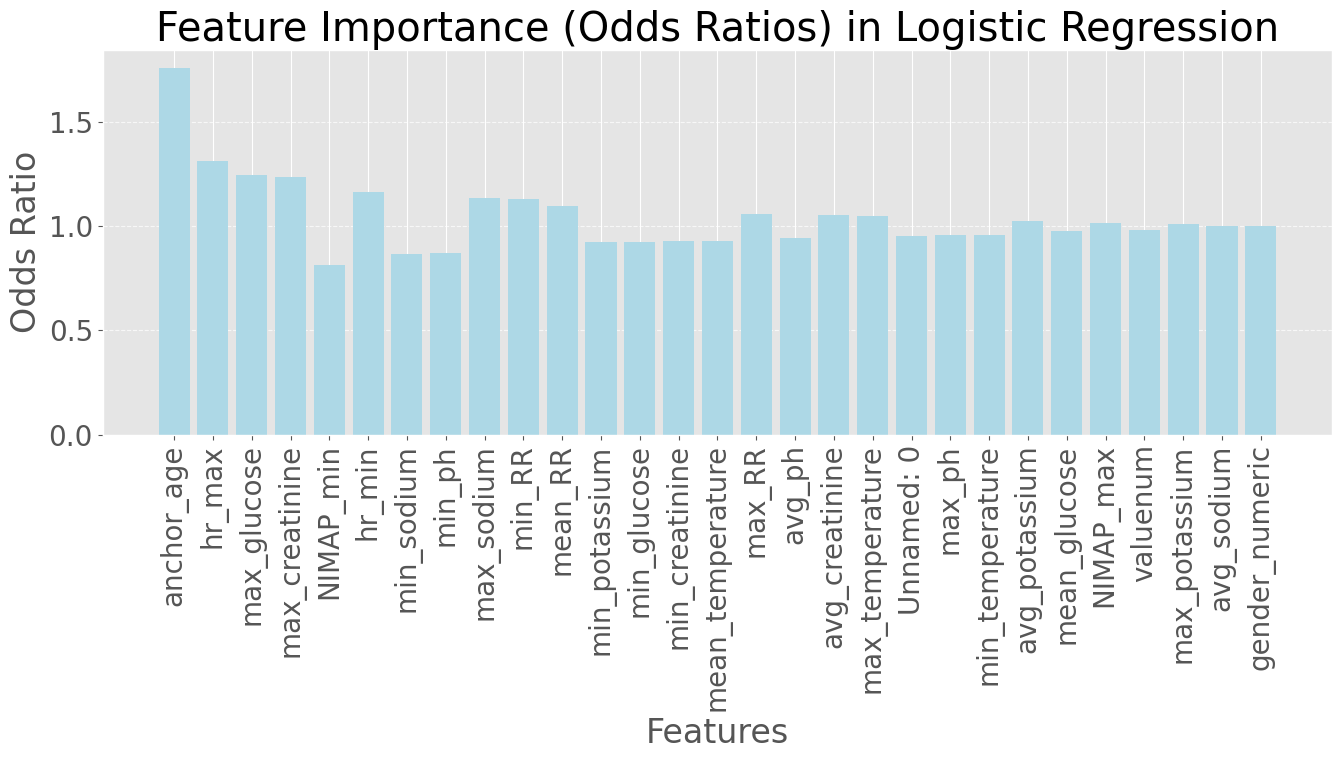

Accuracy on Validation Set: 0.7371126228269086
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     12317
           1       0.15      0.60      0.24       913

    accuracy                           0.74     13230
   macro avg       0.56      0.67      0.54     13230
weighted avg       0.91      0.74      0.80     13230

Confusion Matrix (Validation Set):
[[9205 3112]
 [ 366  547]]
Accuracy on Test Set: 0.676
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.78      0.71      1000
           1       0.72      0.58      0.64      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.67      2000
weighted avg       0.68      0.68      0.67      2000

Confusion Matrix (Test Set):
[[775 225]
 [423 577]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np

# Drop non-feature columns
data = full_training
#df9 = df8.drop_du
# Separate features and target variable
X = data.drop(columns=['label'])
y = data['label']

X_test = full_testing.drop(columns=['label'])
y_test = full_testing['label']

# Split the data, ensuring a balanced class distribution in the test set
# Split the data, ensuring a balanced class distribution in both evaluation and test sets
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Data scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_eval = scaler.transform(X_eval)
X_test = scaler.transform(X_test)

# Handle class imbalance with oversampling and downsampling in the training set only
oversample = SMOTE(sampling_strategy=0.5, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

# Combine resampling techniques in a pipeline
sampling_pipeline = Pipeline(steps=[('over', oversample), ('under', undersample)])

# Apply the pipeline to the training data
X_train_res, y_train_res = sampling_pipeline.fit_resample(X_train, y_train)


label_counts = y_train_res.value_counts()
print("Unique label counts:\n", label_counts)

# Print the total number of unique labels
print("Total number of unique labels:", len(label_counts))

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform k-fold cross-validation (e.g., 5-fold)
kfold = StratifiedKFold(n_splits=10)
cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=kfold, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")


# Fit the model to the resampled training data
model.fit(X_train_res, y_train_res)
feature_names = X.columns  # Assuming X is your DataFrame of features
coefficients = model.coef_[0]  # Get coefficients for logistic regression model
#Create a DataFrame of feature importance

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate odds ratios for interpretability (optional)
feature_importance['Odds Ratio'] = np.exp(feature_importance['Coefficient'])

# Sort features by the absolute value of the coefficient
feature_importance['Abs Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs Coefficient', ascending=False)

import matplotlib.pyplot as plt

# Plot feature importances with vertical bars
plt.figure(figsize=(14, 8))  # Adjust size for better readability
plt.bar(
    x=feature_importance['Feature'],            # Feature names on the x-axis
    height=feature_importance['Odds Ratio'],    # Odds Ratios on the y-axis
    color='lightblue'                           # Bar color
)
plt.xticks(rotation=90)                         # Rotate feature names for readability
plt.ylabel("Odds Ratio")                        # Y-axis label
plt.xlabel("Features")                          # X-axis label
plt.title("Feature Importance (Odds Ratios) in Logistic Regression")  # Title
plt.grid(axis='y', linestyle='--', alpha=0.7)   # Optional grid for y-axis
plt.tight_layout()                              # Adjust layout to fit labels
plt.show()
# Use the evaluation set to measure intermediate performance
y_eval_pred = model.predict(X_eval)
print("Accuracy on Validation Set:", accuracy_score(y_eval, y_eval_pred))
print("Classification Report (Validation Set):")
print(classification_report(y_eval, y_eval_pred))
print("Confusion Matrix (Validation Set):")
print(confusion_matrix(y_eval, y_eval_pred))

# Use the testing dataset to measure final performance
y_test_pred = model.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_test_pred))
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))